In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Setting options
n=800
pd.set_option('display.max_columns',n)
pd.set_option("display.max_info_rows", n)
pd.set_option('display.max_info_columns',n)
from sklearn import set_config
set_config(transform_output='pandas')

In [2]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
def classification_metrics(y_true, y_pred, label="",
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict
    
    
    
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

In [4]:
# Load Data
df = pd.read_csv('Data/pd_speech_features.csv')
df.head()

,id,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,locAbsJitter,rapJitter,ppq5Jitter,ddpJitter,locShimmer,locDbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,meanAutoCorrHarmonicity,meanNoiseToHarmHarmonicity,meanHarmToNoiseHarmonicity,minIntensity,maxIntensity,meanIntensity,f1,f2,f3,f4,b1,b2,b3,b4,GQ_prc5_95,GQ_std_cycle_open,GQ_std_cycle_closed,GNE_mean,GNE_std,GNE_SNR_TKEO,GNE_SNR_SEO,GNE_NSR_TKEO,GNE_NSR_SEO,VFER_mean,VFER_std,VFER_entropy,VFER_SNR_TKEO,VFER_SNR_SEO,VFER_NSR_TKEO,VFER_NSR_SEO,IMF_SNR_SEO,IMF_SNR_TKEO,IMF_SNR_entropy,IMF_NSR_SEO,IMF_NSR_TKEO,IMF_NSR_entropy,mean_Log_energy,mean_MFCC_0th_coef,mean_MFCC_1st_coef,mean_MFCC_2nd_coef,mean_MFCC_3rd_coef,mean_MFCC_4th_coef,mean_MFCC_5th_coef,mean_MFCC_6th_coef,mean_MFCC_7th_coef,mean_MFCC_8th_coef,mean_MFCC_9th_coef,mean_MFCC_10th_coef,mean_MFCC_11th_coef,mean_MFCC_12th_coef,mean_delta_log_energy,mean_0th_delta,mean_1st_delta,mean_2nd_delta,mean_3rd_delta,mean_4th_delta,mean_5th_delta,mean_6th_delta,mean_7th_delta,mean_8th_delta,mean_9th_delta,mean_10th_delta,mean_11th_delta,mean_12th_delta,mean_delta_delta_log_energy,mean_delta_delta_0th,mean_1st_delta_delta,mean_2nd_delta_delta,mean_3rd_delta_delta,mean_4th_delta_delta,mean_5th_delta_delta,mean_6th_delta_delta,mean_7th_delta_delta,mean_8th_delta_delta,mean_9th_delta_delta,mean_10th_delta_delta,mean_11th_delta_delta,mean_12th_delta_delta,std_Log_energy,std_MFCC_0th_coef,std_MFCC_1st_coef,std_MFCC_2nd_coef,std_MFCC_3rd_coef,std_MFCC_4th_coef,std_MFCC_5th_coef,std_MFCC_6th_coef,std_MFCC_7th_coef,std_MFCC_8th_coef,std_MFCC_9th_coef,std_MFCC_10th_coef,std_MFCC_11th_coef,std_MFCC_12th_coef,std_delta_log_energy,std_0th_delta,std_1st_delta,std_2nd_delta,std_3rd_delta,std_4th_delta,std_5th_delta,std_6th_delta,std_7th_delta,std_8th_delta,std_9th_delta,std_10th_delta,std_11th_delta,std_12th_delta,std_delta_delta_log_energy,std_delta_delta_0th,std_1st_delta_delta,std_2nd_delta_delta,std_3rd_delta_delta,std_4th_delta_delta,std_5th_delta_delta,std_6th_delta_delta,std_7th_delta_delta,std_8th_delta_delta,std_9th_delta_delta,std_10th_delta_delta,std_11th_delta_delta,std_12th_delta_delta,Ea,Ed_1_coef,Ed_2_coef,Ed_3_coef,Ed_4_coef,Ed_5_coef,Ed_6_coef,Ed_7_coef,Ed_8_coef,Ed_9_coef,Ed_10_coef,det_entropy_shannon_1_coef,det_entropy_shannon_2_coef,det_entropy_shannon_3_coef,det_entropy_shannon_4_coef,det_entropy_shannon_5_coef,det_entropy_shannon_6_coef,det_entropy_shannon_7_coef,det_entropy_shannon_8_coef,det_entropy_shannon_9_coef,det_entropy_shannon_10_coef,det_entropy_log_1_coef,det_entropy_log_2_coef,det_entropy_log_3_coef,det_entropy_log_4_coef,det_entropy_log_5_coef,det_entropy_log_6_coef,det_entropy_log_7_coef,det_entropy_log_8_coef,det_entropy_log_9_coef,det_entropy_log_10_coef,det_TKEO_mean_1_coef,det_TKEO_mean_2_coef,det_TKEO_mean_3_coef,det_TKEO_mean_4_coef,det_TKEO_mean_5_coef,det_TKEO_mean_6_coef,det_TKEO_mean_7_coef,det_TKEO_mean_8_coef,det_TKEO_mean_9_coef,det_TKEO_mean_10_coef,det_TKEO_std_1_coef,det_TKEO_std_2_coef,det_TKEO_std_3_coef,det_TKEO_std_4_coef,det_TKEO_std_5_coef,det_TKEO_std_6_coef,det_TKEO_std_7_coef,det_TKEO_std_8_coef,det_TKEO_std_9_coef,det_TKEO_std_10_coef,app_entropy_shannon_1_coef,app_entropy_shannon_2_coef,app_entropy_shannon_3_coef,app_entropy_shannon_4_coef,app_entropy_shannon_5_coef,app_entropy_shannon_6_coef,app_entropy_shannon_7_coef,app_entropy_shannon_8_coef,app_entropy_shannon_9_coef,app_entropy_shannon_10_coef,app_entropy_log_1_coef,app_entropy_log_2_coef,app_entropy_log_3_coef,app_entropy_log_4_coef,app_entropy_log_5_coef,app_entropy_log_6_coef,app_entropy_log_7_coef,app_entropy_log_8_coef,app_entropy_log_9_coef,app_entropy_log_10_coef,app_det_TKEO_mean_1_coef,app_det_TKEO_mean_2_coef,app_det_TKEO_mean_3_coef,app_det_TKEO_mean_4_coef,app_det_TKEO_mean_5_coef,app_det_TKEO_mean_6_coef,app_det_TKEO_mean_7_coef,app_det_TKEO_mean_8_coef,app_det_TKEO_mean_9_coef,app_det_TKEO_mean_10_coef,app_TKEO_std_1_coef,app_TKEO_std_2_coef,app_TKEO_

In [5]:
# Preprocessing

# Check for null values
df.isna().sum().sum

# Checking the unique dtypes
df.dtypes.unique()

# Define target
target_col = 'class'

# Make list of columns to drop. In this case just the id column for now
drop_cols = ['id']

# Define X and y
y = df[target_col].copy()
X = df.drop(columns=[target_col,*drop_cols]).copy()

# Train test split
X_train,X_test,y_train,y_test = train_test_split(X,y, random_state=42)

In [6]:
# Scale
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [7]:
# Check the balance of the target
y.value_counts(1)

1    0.746032
0    0.253968
Name: class, dtype: float64

In [8]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state = 42)
X_train_sm,y_train_sm = smote.fit_resample(X_train_scaled, y_train)
y_train_sm.value_counts()

1    427
0    427
Name: class, dtype: int64

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       427
           1       1.00      1.00      1.00       427

    accuracy                           1.00       854
   macro avg       1.00      1.00      1.00       854
weighted avg       1.00      1.00      1.00       854



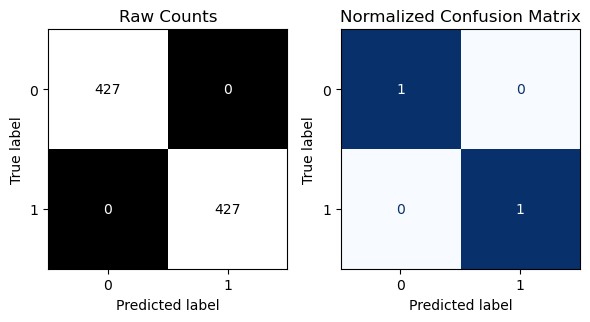


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.73      0.63      0.68        52
           1       0.87      0.91      0.89       137

    accuracy                           0.84       189
   macro avg       0.80      0.77      0.79       189
weighted avg       0.83      0.84      0.83       189



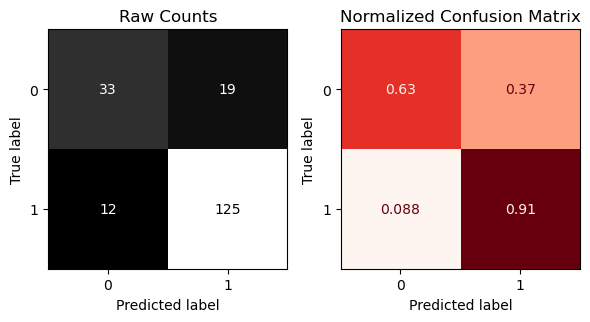

In [9]:
# Modeling

# Instantiate a default random forest with a random state for reproductibility
rf_clf = RandomForestClassifier(random_state=42)

# Fit on the training data
rf_clf.fit(X_train_sm, y_train_sm)

# Evaluate with the custom function
evaluate_classification(rf_clf, X_train_sm,y_train_sm, X_test_scaled, y_test)

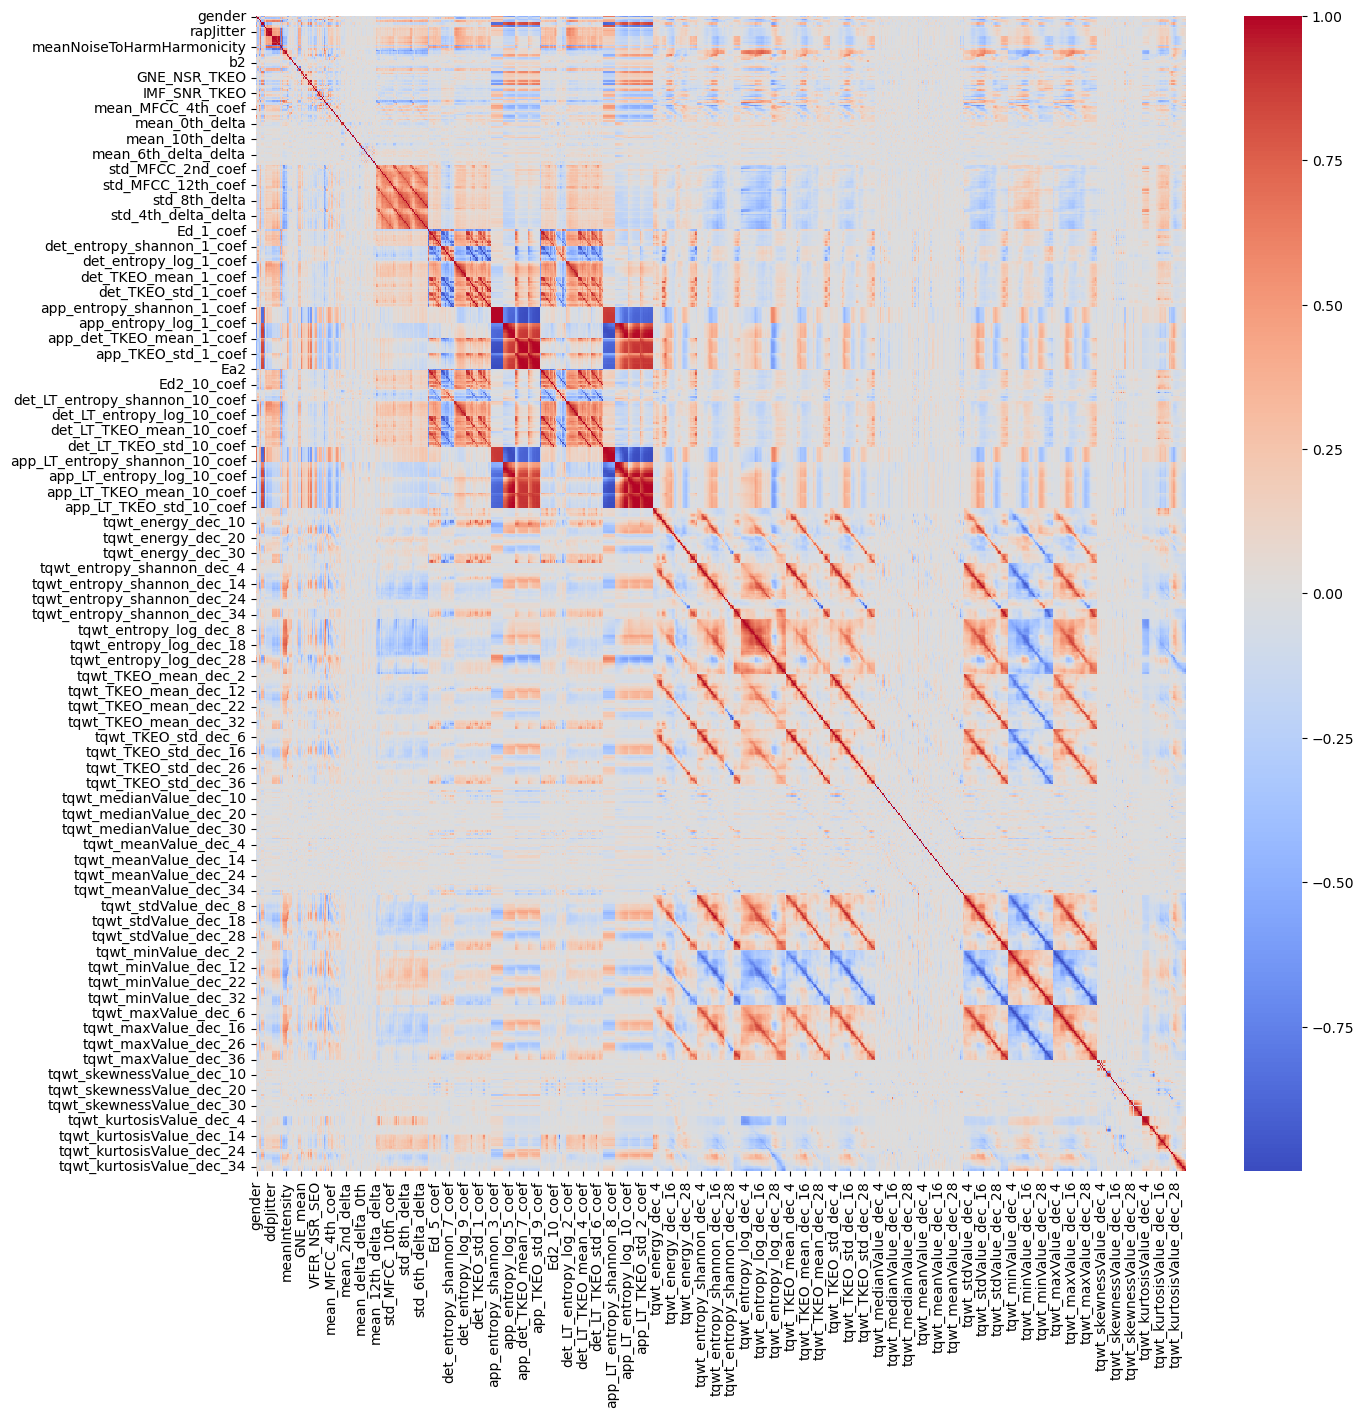

In [10]:
# FILTER METHODS

# Example Filter Method - Correlation

# Make a correlation heatmap of all features
corr = X_train_sm.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr,cmap='coolwarm');

In [11]:
from collinearity import SelectNonCollinear
from sklearn.feature_selection import f_classif

In [12]:
# Instantiate the selector, indicate theshold for r, also include the appropriate scoring metric for the task
selector = SelectNonCollinear(correlation_threshold = 0.75, scoring = f_classif)

In [13]:
# Fit on the training data, use .values
selector.fit(X_train_sm.values, y_train_sm.values)

In [14]:
# Define a mask for filtering
non_collinear = selector.get_support()
non_collinear[:5]

[True, True, True, True, False]

In [15]:
# Check how many features are below the theshold
non_collinear.count(True)

299

In [16]:
# Check how many features are above the theshold
non_collinear.count(False)

454

In [17]:
# Make the T/F a series with the column names as the index
non_collinear_series = pd.Series(selector.get_support(), index=X_train_sm.columns)
non_collinear_series

gender                        True
PPE                           True
DFA                           True
RPDE                          True
numPulses                    False
                             ...  
tqwt_kurtosisValue_dec_32    False
tqwt_kurtosisValue_dec_33     True
tqwt_kurtosisValue_dec_34    False
tqwt_kurtosisValue_dec_35    False
tqwt_kurtosisValue_dec_36     True
Length: 753, dtype: bool

In [18]:
# Filter training data
training_data_to_keep = X_train_sm.values[:, non_collinear]
# Filter column names
columns = np.array(X_train_sm.columns)[non_collinear]
# Make traing data into a dataframe
X_train_no_corr = pd.DataFrame(training_data_to_keep, columns = columns)

# Filter testing data
test_data_to_keep = X_test_scaled.values[:, non_collinear]
# Make test data into a dataframe
X_test_no_corr = pd.DataFrame(test_data_to_keep, columns = columns)

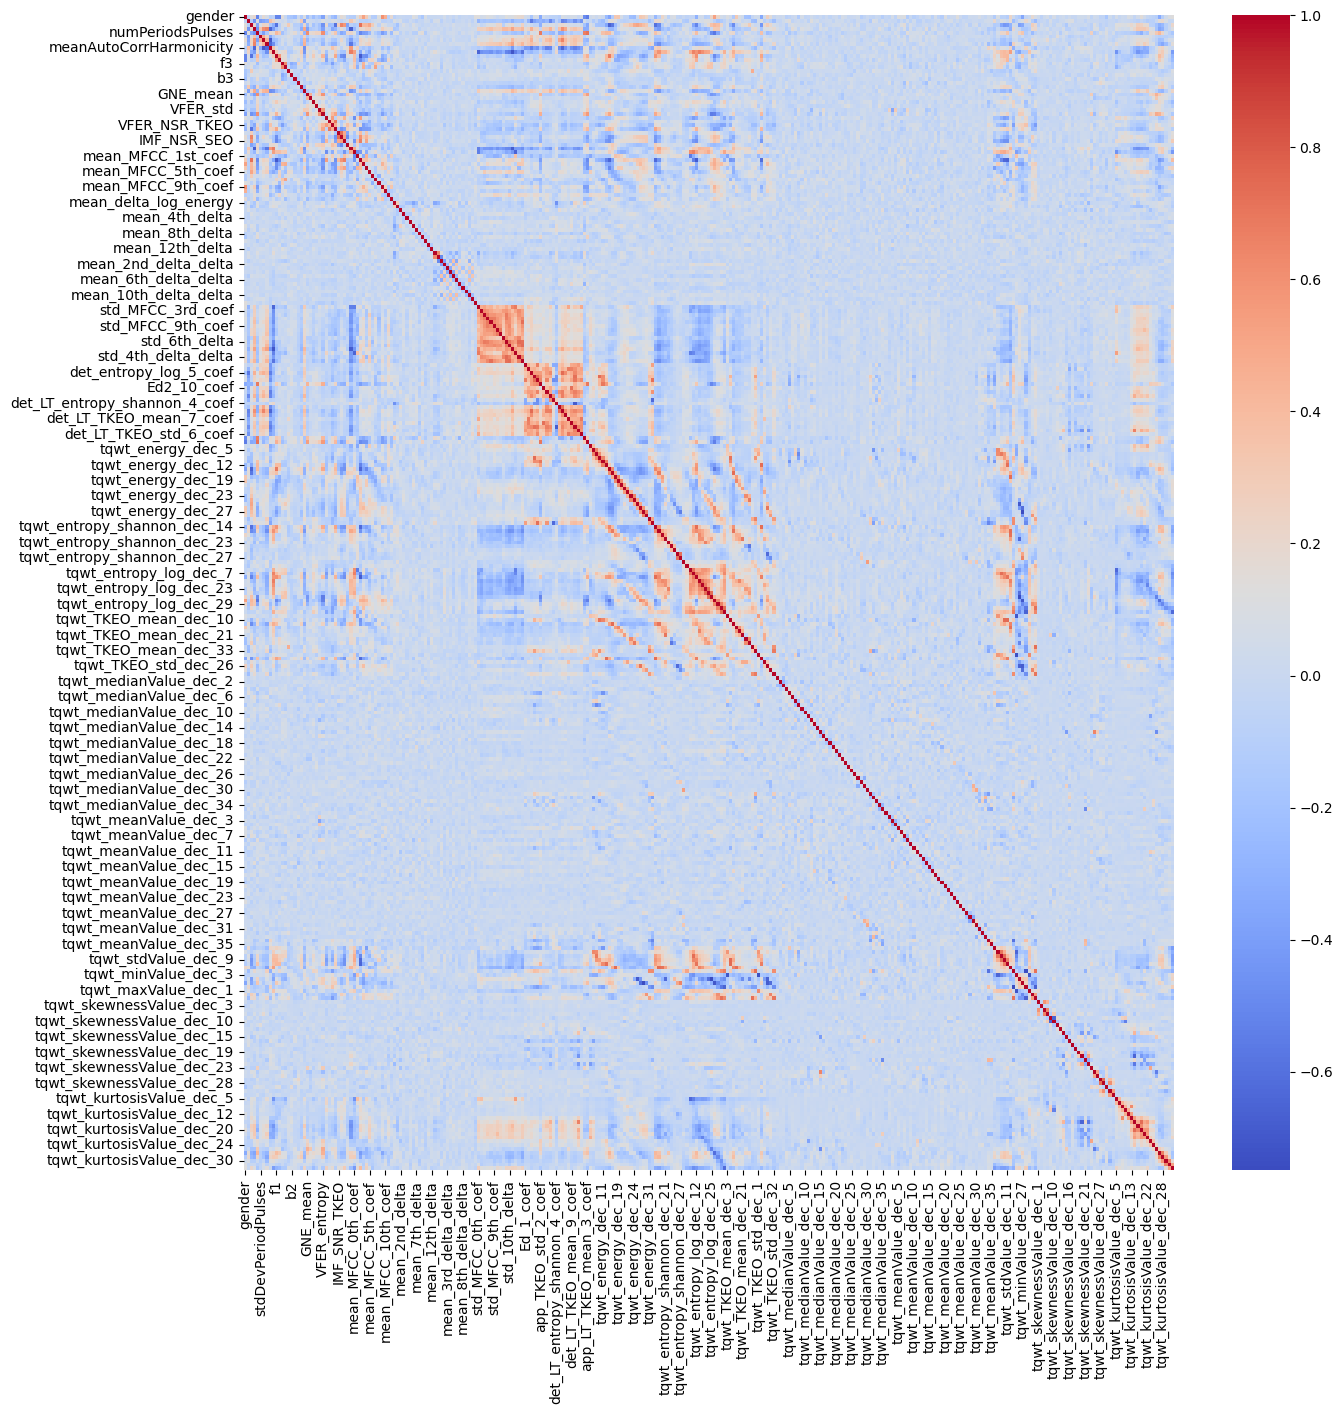

In [22]:
# Make correlation heatmap for non_collinear features
corr = X_train_no_corr.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr,cmap='coolwarm');

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       427
           1       1.00      1.00      1.00       427

    accuracy                           1.00       854
   macro avg       1.00      1.00      1.00       854
weighted avg       1.00      1.00      1.00       854



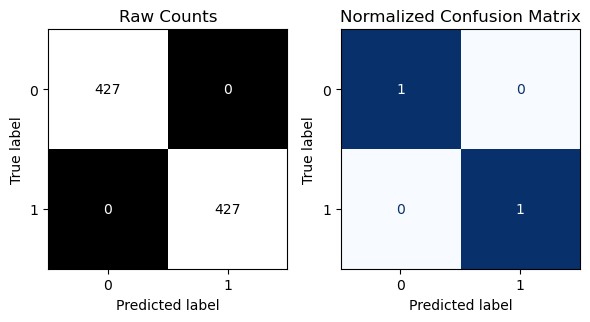


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.76      0.60      0.67        52
           1       0.86      0.93      0.89       137

    accuracy                           0.84       189
   macro avg       0.81      0.76      0.78       189
weighted avg       0.83      0.84      0.83       189



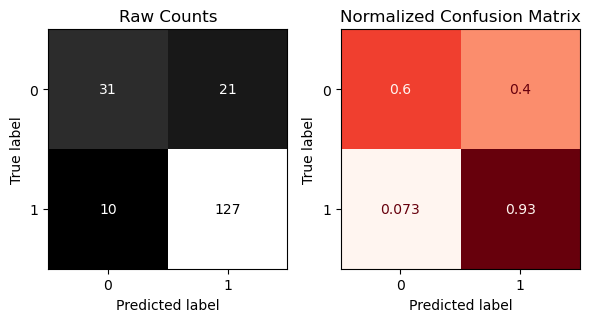

In [23]:
# Test the performance
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train_no_corr, y_train_sm)
evaluate_classification(rf_clf, X_train_no_corr, y_train_sm, X_test_no_corr, y_test)

In [24]:
# EXAMPLE FILTER METHOD- VARIANCE

from sklearn.feature_selection import VarianceThreshold

In [25]:
# checking for constant-features
selector = VarianceThreshold(threshold=0.00)
selector.fit(X_train)

VarianceThreshold()

In [26]:
# get support returns true/false for keeping features
keep_features = selector.get_support()
keep_features[:5]

array([ True,  True,  True,  True,  True])

In [27]:
# Number of features to keep (non-constant features)
keep_features.sum()

753

In [28]:
# checking for quasi-constant-features
selector = VarianceThreshold(threshold=0.01)
selector.fit(X_train)

VarianceThreshold(threshold=0.01)

In [29]:
# get support returns true/false for keeping features
keep_features = selector.get_support()
keep_features[:5]

array([ True,  True, False,  True,  True])

In [30]:
# Number of features to keep (non-quasi-constant features)
keep_features.sum()

425

In [31]:
# Filter based on variance
X_train_var = X_train.loc[:,keep_features]
X_test_var = X_test.loc[:,keep_features]
X_train_var

,gender,PPE,RPDE,numPulses,numPeriodsPulses,locDbShimmer,meanNoiseToHarmHarmonicity,meanHarmToNoiseHarmonicity,minIntensity,maxIntensity,meanIntensity,f1,f2,f3,f4,b1,b2,b3,b4,GQ_prc5_95,GQ_std_cycle_open,GQ_std_cycle_closed,GNE_mean,GNE_std,GNE_SNR_SEO,VFER_entropy,VFER_SNR_TKEO,VFER_SNR_SEO,IMF_SNR_SEO,IMF_SNR_TKEO,IMF_SNR_entropy,IMF_NSR_TKEO,mean_Log_energy,mean_MFCC_0th_coef,mean_MFCC_1st_coef,mean_MFCC_2nd_coef,mean_MFCC_3rd_coef,mean_MFCC_4th_coef,mean_MFCC_5th_coef,mean_MFCC_6th_coef,mean_MFCC_7th_coef,mean_MFCC_8th_coef,mean_MFCC_9th_coef,mean_MFCC_10th_coef,mean_MFCC_11th_coef,mean_MFCC_12th_coef,std_Log_energy,std_MFCC_0th_coef,std_MFCC_1st_coef,std_MFCC_2nd_coef,std_MFCC_3rd_coef,std_MFCC_4th_coef,std_MFCC_5th_coef,std_MFCC_6th_coef,Ea,Ed_10_coef,det_entropy_shannon_1_coef,det_entropy_shannon_2_coef,det_entropy_shannon_3_coef,det_entropy_shannon_4_coef,det_entropy_shannon_5_coef,det_entropy_shannon_6_coef,det_entropy_shannon_7_coef,det_entropy_shannon_8_coef,det_entropy_shannon_9_coef,det_entropy_shannon_10_coef,det_entropy_log_1_coef,det_entropy_log_2_coef,det_entropy_log_3_coef,det_entropy_log_4_coef,det_entropy_log_5_coef,det_entropy_log_6_coef,det_entropy_log_7_coef,det_entropy_log_8_coef,det_entropy_log_9_coef,det_entropy_log_10_coef,det_TKEO_mean_1_coef,det_TKEO_mean_2_coef,det_TKEO_mean_3_coef,det_TKEO_mean_4_coef,det_TKEO_mean_5_coef,det_TKEO_mean_6_coef,det_TKEO_mean_7_coef,det_TKEO_mean_8_coef,det_TKEO_mean_9_coef,det_TKEO_mean_10_coef,det_TKEO_std_1_coef,det_TKEO_std_2_coef,det_TKEO_std_3_coef,det_TKEO_std_4_coef,det_TKEO_std_5_coef,det_TKEO_std_6_coef,det_TKEO_std_7_coef,det_TKEO_std_8_coef,det_TKEO_std_9_coef,det_TKEO_std_10_coef,app_entropy_shannon_1_coef,app_entropy_shannon_2_coef,app_entropy_shannon_3_coef,app_entropy_shannon_4_coef,app_entropy_shannon_5_coef,app_entropy_shannon_6_coef,app_entropy_shannon_7_coef,app_entropy_shannon_8_coef,app_entropy_shannon_9_coef,app_entropy_shannon_10_coef,app_entropy_log_1_coef,app_entropy_log_2_coef,app_entropy_log_3_coef,app_entropy_log_4_coef,app_entropy_log_5_coef,app_entropy_log_6_coef,app_entropy_log_7_coef,app_entropy_log_8_coef,app_entropy_log_9_coef,app_entropy_log_10_coef,app_det_TKEO_mean_1_coef,app_det_TKEO_mean_2_coef,app_det_TKEO_mean_3_coef,app_det_TKEO_mean_4_coef,app_det_TKEO_mean_5_coef,app_det_TKEO_mean_6_coef,app_det_TKEO_mean_7_coef,app_det_TKEO_mean_8_coef,app_det_TKEO_mean_9_coef,app_det_TKEO_mean_10_coef,app_TKEO_std_1_coef,app_TKEO_std_2_coef,app_TKEO_std_3_coef,app_TKEO_std_4_coef,app_TKEO_std_5_coef,app_TKEO_std_6_coef,app_TKEO_std_7_coef,app_TKEO_std_8_coef,app_TKEO_std_9_coef,app_TKEO_std_10_coef,det_LT_entropy_shannon_1_coef,det_LT_entropy_shannon_2_coef,det_LT_entropy_shannon_3_coef,det_LT_entropy_shannon_4_coef,det_LT_entropy_shannon_5_coef,det_LT_entropy_shannon_6_coef,det_LT_entropy_shannon_7_coef,det_LT_entropy_shannon_8_coef,det_LT_entropy_shannon_9_coef,det_LT_entropy_shannon_10_coef,det_LT_entropy_log_1_coef,det_LT_entropy_log_2_coef,det_LT_entropy_log_3_coef,det_LT_entropy_log_4_coef,det_LT_entropy_log_5_coef,det_LT_entropy_log_6_coef,det_LT_entropy_log_7_coef,det_LT_entropy_log_8_coef,det_LT_entropy_log_9_coef,det_LT_entropy_log_10_coef,det_LT_TKEO_mean_4_coef,det_LT_TKEO_mean_5_coef,det_LT_TKEO_mean_6_coef,det_LT_TKEO_mean_7_coef,det_LT_TKEO_mean_8_coef,det_LT_TKEO_mean_9_coef,det_LT_TKEO_mean_10_coef,det_LT_TKEO_std_4_coef,det_LT_TKEO_std_5_coef,det_LT_TKEO_std_6_coef,det_LT_TKEO_std_7_coef,det_LT_TKEO_std_8_coef,det_LT_TKEO_std_9_coef,det_LT_TKEO_std_10_coef,app_LT_entropy_shannon_1_coef,app_LT_entropy_shannon_2_coef,app_LT_entropy_shannon_3_coef,app_LT_entropy_shannon_4_coef,app_LT_entropy_shannon_5_coef,app_LT_entropy_shannon_6_coef,app_LT_entropy_shannon_7_coef,app_LT_entropy_shannon_8_coef,app_LT_entropy_shannon_9_coef,app_LT_entropy_shannon_10_coef,app_LT_entropy_log_1_coef,app_LT_entropy_log_2_coef,app_LT_entropy_log_3_coef,app_LT_entropy_log_4_coef,app_LT_entropy_log_5_coef,app_LT_entropy_log_6_coef,app_LT_entropy

In [32]:
## Now that we have dataframes where features were selected based on variance, we will scale and oversample them with SMOTE before modeling.

# Use standardscaler to Scale
scaler = StandardScaler()
scaler.fit(X_train_var)
X_train_var_scaled = scaler.transform(X_train_var)
X_test_var_scaled = standard=scaler.transform(X_test_var)

In [33]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state = 42)
X_train_var_scaled_sm, y_train_sm = smote.fit_resample(X_train_var_scaled, y_train)
y_train_sm.value_counts()

1    427
0    427
Name: class, dtype: int64

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       427
           1       1.00      1.00      1.00       427

    accuracy                           1.00       854
   macro avg       1.00      1.00      1.00       854
weighted avg       1.00      1.00      1.00       854



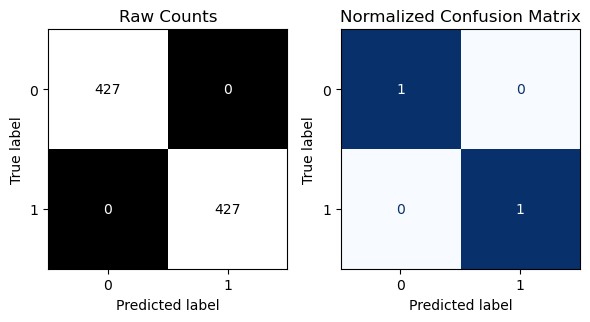


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.73      0.75        52
           1       0.90      0.92      0.91       137

    accuracy                           0.87       189
   macro avg       0.84      0.83      0.83       189
weighted avg       0.87      0.87      0.87       189



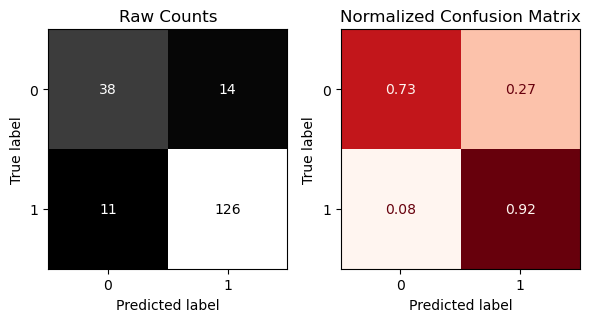

In [34]:
# Test the performance
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train_var_scaled_sm, y_train_sm)
evaluate_classification(rf_clf, X_train_var_scaled_sm, y_train_sm, X_test_var_scaled, y_test)

In [35]:
# FEATURE SELECTION 2

from sklearn.feature_selection import SelectFromModel

# Instantiate a lostistic regression model
log_reg = LogisticRegression(C=1e12)
# Define the selector object using the model. Use default threshold (mean)
selector = SelectFromModel(log_reg)
# Fit the selector on the training data
selector.fit(X_train_sm ,y_train_sm)
selector

SelectFromModel(estimator=LogisticRegression(C=1000000000000.0))

In [36]:
# Obtain threshold used
selector.threshold_

1.2689423868479364

In [37]:
# What is the shape of the output for coefficents?
selector.estimator_.coef_.shape

(1, 753)

In [38]:
# View first coefficient
selector.estimator_.coef_[0,0]

3.3222652815762186

In [39]:
# Reduce this array to one dimension
flattened = selector.estimator_.coef_.flatten() 
flattened.shape

(753,)

In [40]:
# Access first value of 1d array
flattened[0]

3.3222652815762186

In [41]:
# Make the coefs a series with the column names as the index
coeffs = pd.Series(flattened, index=X_train_sm.columns)
coeffs

gender                       3.322265
PPE                         -1.422290
DFA                          0.591989
RPDE                         2.719438
numPulses                    0.904282
                               ...   
tqwt_kurtosisValue_dec_32    2.818281
tqwt_kurtosisValue_dec_33    6.575284
tqwt_kurtosisValue_dec_34    2.410255
tqwt_kurtosisValue_dec_35    1.986878
tqwt_kurtosisValue_dec_36    1.354099
Length: 753, dtype: float64

In [42]:
# .get_support returns an array of T/F whether it is above threshold
above_threshold = selector.get_support()
above_threshold[0:5]

array([ True,  True, False,  True, False])

In [43]:
# Filter the coeffs series to include only those above the threshold
coeffs[above_threshold]

gender                       3.322265
PPE                         -1.422290
RPDE                         2.719438
meanPeriodPulses            -2.890861
locPctJitter                 1.360323
                               ...   
tqwt_kurtosisValue_dec_32    2.818281
tqwt_kurtosisValue_dec_33    6.575284
tqwt_kurtosisValue_dec_34    2.410255
tqwt_kurtosisValue_dec_35    1.986878
tqwt_kurtosisValue_dec_36    1.354099
Length: 289, dtype: float64

In [44]:
# now we have completed out additional exploration

In [45]:
## If we didn't wish to explore, we would filter our data after fitting the selector as shown below.

# .get_support returns an array of T/F whether it is above threshold
above_threshold = selector.get_support()
# Only include the features that are above the threshold in X train and X test
X_train_sel = X_train_sm.loc[:,above_threshold]
X_test_sel = X_test_scaled.loc[:,above_threshold]
X_train_sel.shape

(854, 289)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       427
           1       1.00      1.00      1.00       427

    accuracy                           1.00       854
   macro avg       1.00      1.00      1.00       854
weighted avg       1.00      1.00      1.00       854



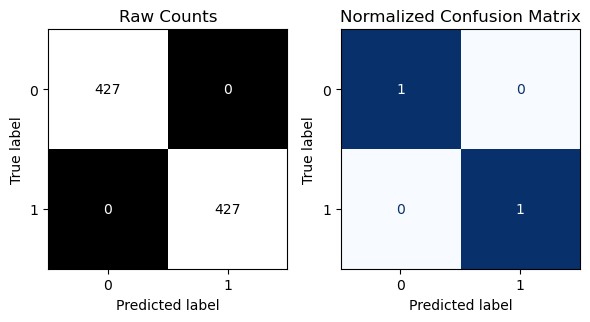


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.69      0.69      0.69        52
           1       0.88      0.88      0.88       137

    accuracy                           0.83       189
   macro avg       0.79      0.79      0.79       189
weighted avg       0.83      0.83      0.83       189



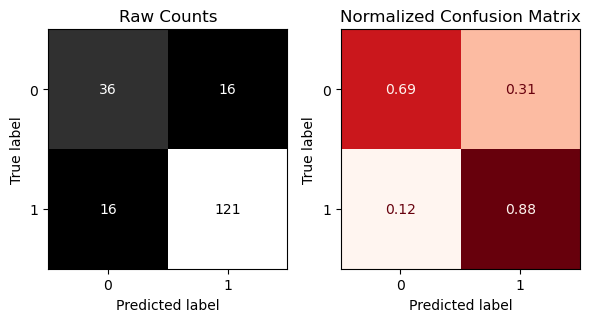

In [46]:
# Instantiate default random forest
rf_clf = RandomForestClassifier(random_state=42)
# Fit on selected featuers
rf_clf.fit(X_train_sel, y_train_sm)
# Evaluate with custom function
evaluate_classification(rf_clf, X_train_sel, y_train_sm, X_test_sel, y_test)

In [47]:
# Example Wrapper Method-Using  Forward Selection

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.tree import DecisionTreeClassifier

# Instantiate the model
dt = DecisionTreeClassifier(random_state = 42)

In [48]:
# Instantiate the SequentialFeatureSelector
sk_sfs = SequentialFeatureSelector(dt, n_features_to_select=50,
                                direction = 'forward', cv=2,
                                 n_jobs=-1)
sk_sfs.fit(X_train_sel,y_train_sm)

SequentialFeatureSelector(cv=2,
                          estimator=DecisionTreeClassifier(random_state=42),
                          n_features_to_select=50, n_jobs=-1)

In [49]:
# Preview array of T/F for selected (or not) features
sk_sfs.support_[0:5]

array([ True, False,  True, False, False])

In [50]:
# .support_ returns an array of T/F whether it is above threshold
features_to_keep = sk_sfs.support_
# Only include the features selected
X_train_50 = X_train_sel.loc[:,features_to_keep]
X_test_50 = X_test_sel.loc[:,features_to_keep]
X_train_50.shape

(854, 50)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       427
           1       1.00      1.00      1.00       427

    accuracy                           1.00       854
   macro avg       1.00      1.00      1.00       854
weighted avg       1.00      1.00      1.00       854



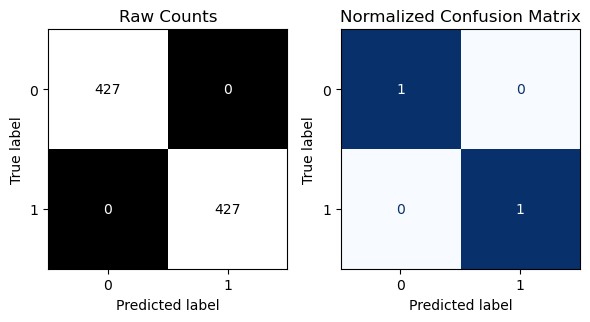


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.67      0.71      0.69        52
           1       0.89      0.87      0.88       137

    accuracy                           0.83       189
   macro avg       0.78      0.79      0.78       189
weighted avg       0.83      0.83      0.83       189



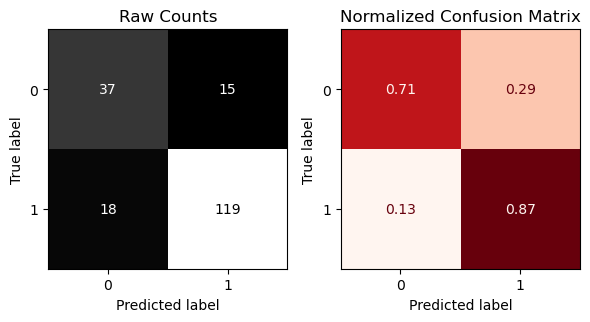

In [51]:
# Instantiate default random forest
rf_clf = RandomForestClassifier(random_state=42)
# Fit on 50 selected featuers
rf_clf.fit(X_train_50, y_train_sm)
# Evaluate with custom function
evaluate_classification(rf_clf, X_train_50, y_train_sm, X_test_50, y_test)